In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)
import glob
import matplotlib.pyplot as plt
import act
import xarray as xr
import scipy.signal
import datetime as dt

# User Inputs

In [7]:
ds_dl_fpt = 'gucdlfptM1.b1'
startdate = '2022-10-30'
enddate = '2022-11-01'
SNR_THRESHOLD = 0.008

In [8]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Download datasets

In [9]:
act.discovery.download_data(username, token, ds_dl_fpt, startdate, enddate)
!du -sh gucdlfptM1.b1 

[DOWNLOADING] gucdlfptM1.b1.20221031.230103.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.000102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.010102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.020102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.050103.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.030102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.040102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.060102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.100101.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.120102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.110102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.130042.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.200103.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.180102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.190102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221030.230102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221031.000102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221031.010102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221031.020102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221031.050102.cdf
[DOWNLOADING] gucdlfptM1.b1.20221031.100

In [10]:
dl_fpt_files = glob.glob(''.join(['./',ds_dl_fpt,'/*cdf']))

In [11]:
dl_fpt = act.io.armfiles.read_netcdf(dl_fpt_files)

# Calculate SNR and Filter

In [21]:
dl_fpt['SNR'] = dl_fpt['intensity'] - 1
dl_fpt['radial_velocity'] = dl_fpt.where(dl_fpt['SNR'] > SNR_THRESHOLD)['radial_velocity']

<AxesSubplot: title={'center': 'Gothic Doppler LiDAR radial_velocity on 20221030'}, xlabel='Time [UTC]', ylabel='(m)'>

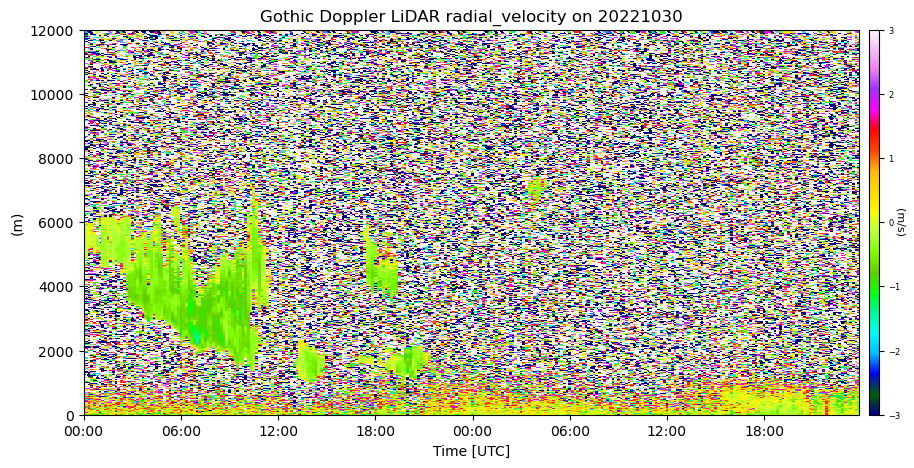

In [22]:
plotting_dataset = dl_fpt.resample(time='10Min').mean()
display = act.plotting.TimeSeriesDisplay(
    {'Gothic Doppler LiDAR': plotting_dataset},
    subplot_shape=(1,),
    figsize=(10, 5),
)

display.plot(
    'radial_velocity',
    dsname='Gothic Doppler LiDAR',
    cmap='gist_ncar',
    vmin=-3,
    vmax=3,
    subplot_index=(0,)
)


# Create DF

In [ ]:
src_fpt = dl_fpt.to_dataframe().reset_index()

In [ ]:
src_fpt.azimuth.unique(), src_fpt.elevation.unique(), src_fpt.lat.unique(), src_fpt.lon.unique()

Make power spectral density functions of the wind speed measured by the vertical stares for:

1. All of the SAIL data to date
2. All data from last winter
3. All data from last spring

Let's see what the power spectral density function looks like by time period ranging from **twice the frequency of the vertical stares that the DL collects** out to a **period of one month**  

There should be a few peaks at daily and sub-daily intervals, Hopefully things at sub-hourly periods are not impacted. Hopefully there aren't too many gaps, because FFTs don't work with gaps.  I trust your judgement for something simple to fill in gaps.  You may consider doing this (https://stackoverflow.com/questions/23083649/fourier-transformation-with-missing-values).


Notes:
* ignore anything above 3km
* break time series into pieces 

# Calculate power spectral density function for a range of 15 meters

In [ ]:
src_fpt['sample_time'] = src_fpt['time'].diff().dt.seconds
src_fpt['radial_velocity_demeaned'] = src_fpt['radial_velocity'] - src_fpt['radial_velocity'].mean()

In [ ]:
src_fpt['epoch'] = (src_fpt['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [ ]:
src_fpt['time'].min(), src_fpt['time'].max()

freqs = np.linspace(1/(60*60*24), 1/2, 100)

In [ ]:
pgram = scipy.signal.lombscargle(
    src_fpt['epoch'],
    src_fpt['radial_velocity_demeaned'],
    freqs
)


In [ ]:
plt.loglog(freqs, pgram)
plt.show()

In [ ]:
src_fpt_first15min = src_fpt[src_fpt['time'].dt.minute<16]

In [ ]:
pgram = scipy.signal.lombscargle(
    src_fpt_first15min['epoch'],
    src_fpt_first15min['radial_velocity_demeaned'],
    freqs
)


In [ ]:
plt.loglog(freqs, pgram)
plt.show()

Statistics: 

* Compute variance of time series - is it same for different 10 minute chunks? is it same for a 40 minute period and for a 10 minute period? 
* Plot: variance on y axis - window length on x axis